In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os, copy
from scipy.stats import multivariate_normal
from sklearn.metrics import precision_score, recall_score

In [2]:
df1 = pd.read_csv('TEK16.txt', names=['value'])
sc = MinMaxScaler()
min_max_array = sc.fit_transform(df1['value'].values.reshape(-1,1))

In [3]:
df1.iloc[:,0] = min_max_array

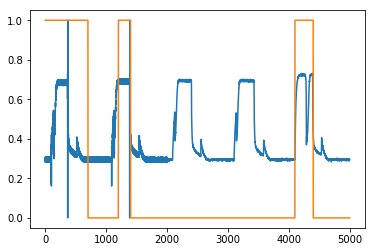

In [4]:
df1['class'] = 0
df1.loc[:700, 'class'] = 1
df1.loc[1200: 1400, 'class'] = 1
df1.loc[4100: 4400, 'class'] = 1
plt.plot(df1)
df1.to_csv('TEK16-labeled.csv', index=False)

In [5]:
# global variable
l = future = 10
past = 20

In [6]:
def get_l_train(x, l):
    '''
    Return: np.array of shape (n, l, 1)
    >>> x = np.arange(1, 6).reshape((5, 1))
    >>> x
    array([[1],
           [2],
           [3],
           [4],
           [5]])
    >>> get_l_test(x, 2)
    array([[[2],
            [3]],
    <BLANKLINE>
           [[3],
            [4]],
    <BLANKLINE>
           [[4],
            [5]]])
    ''' 
    two_d_arr = np.concatenate([np.roll(x, -i) for i in range(0, l)], axis=1)[:-l+1-future]
    
    return two_d_arr.reshape((*two_d_arr.shape, 1))

def get_l_test(x, l):
    '''
    Return: np.array of shape (n, l, 1)
    >>> x = np.arange(1, 6).reshape((5, 1))
    >>> x
    array([[1],
           [2],
           [3],
           [4],
           [5]])
    >>> get_l_test(x, 2)
    array([[[2],
            [3]],
    <BLANKLINE>
           [[3],
            [4]],
    <BLANKLINE>
           [[4],
            [5]]])
    ''' 
    two_d_arr = np.concatenate([np.roll(x, -i) for i in range(0, l)], axis=1)[past:-l+1]
    
    return two_d_arr.reshape((*two_d_arr.shape, 1))
ts_normal = np.array(df1[2000: 4000]['value'])
ts_normal = ts_normal.reshape((ts_normal.shape[0], 1))
X_normal = get_l_train(ts_normal, past)
y_normal = get_l_test(ts_normal, l)

In [7]:
X_normal.shape

(1971, 20, 1)

In [8]:
y_normal.shape

(1971, 10, 1)

In [9]:
ts_anomaly_1 = np.array(df1[4100: 4400]['value']).reshape(-1,1)
X_anomaly_1 = get_l_train(ts_anomaly_1, past)
y_anomaly_1 = get_l_test(ts_anomaly_1, l)
X_anomaly = np.vstack([X_anomaly_1])
y_anomaly = np.vstack([y_anomaly_1])

In [10]:
X_train_normal, X_vali1_normal, X_vali2_normal = X_normal[:-1], X_normal[:1000], X_normal[1000:]
y_train_normal, y_vali1_normal, y_vali2_normal = y_normal[:-1], y_normal[:1000], y_normal[1000:]

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(35, return_sequences=True, input_shape=(past, 1)))
model.add(tf.keras.layers.LSTM(35, return_sequences=True))
model.add(tf.keras.layers.LSTM(35))
model.add(tf.keras.layers.Dense(l))
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit(X_train_normal, 
                    y_train_normal, 
                    epochs=50, 
                    batch_size=128, 
                    validation_data=(X_vali1_normal, y_vali1_normal), 
                    verbose=2, 
                    shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 35)            5180      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 35)            9940      
_________________________________________________________________
lstm_2 (LSTM)                (None, 35)                9940      
_________________________________________________________________
dense (Dense)                (None, 10)                360       
Total params: 25,420
Trainable params: 25,420
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 - 3s - loss: 0.1033 - val_loss: 0.0274
Epoch 2/50
16/16 - 1s - loss: 0.0161 - val_loss: 0.0079
Epoch 3/50
16/16 - 1s - loss: 0.0073 - val_loss: 0.0036
Epoch 4/50
16/16 - 1s - loss: 0.0033 - val_loss: 0.0025
Epoch 5/50
16/16 - 1s - lo

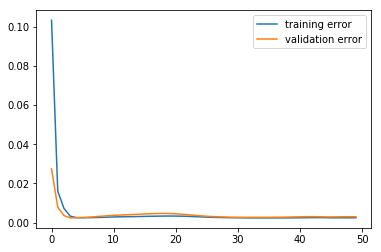

In [12]:
losses = history.history["loss"]
val_losses = history.history["val_loss"]
plt.plot(losses,label='training error')
plt.plot(val_losses,label='validation error')
plt.legend()
plt.show()

In [13]:
def get_error(y_pred, y_test):
    difference = y_test - y_pred
    temp = []
    for i in range(l):
        temp.append(difference[l-1-i:len(difference)-i,i])
    return np.vstack(temp).T

In [14]:
e_vali1 = get_error(model.predict(X_vali1_normal),y_vali1_normal.reshape(-1,l))

In [15]:
# estimate u and sigma
u = np.mean(e_vali1,axis = 0)
sigma = np.zeros((l, l))
for item in e_vali1:
    sigma += (item-u.reshape((l,1))) @ (item-u.reshape((l,1))).T
sigma /= len(e_vali1)

In [16]:
e_vali2 = get_error(model.predict(X_vali2_normal),y_vali2_normal.reshape(-1,l))
e_anomaly = get_error(model.predict(X_anomaly),y_anomaly.reshape(-1,l))

In [17]:
p_vali2 = multivariate_normal.pdf(x=e_vali2, mean=u, cov=sigma, allow_singular=True)
p_anomaly = multivariate_normal.pdf(x=e_anomaly, mean=u, cov=sigma, allow_singular=True)

In [18]:
def F_score(precision, recall, beta=0.1):
    return (1+beta**2)*precision*recall/((beta**2)*precision + recall)

In [19]:
tau_list = [10**(-i) for i in range(-5,40)]
max_tau = 0
position = None
for index, tau in enumerate(tau_list):
    prediction = np.hstack([p_vali2 < tau,p_anomaly < tau])
    real_tag = np.array([0]*len(p_vali2)+[1]*len(p_anomaly))
    precision = precision_score(y_true=real_tag, y_pred=prediction)
    recall = recall_score(y_true=real_tag, y_pred=prediction)
    f_score = F_score(precision, recall)
    if f_score > max_tau:
        max_tau, position = f_score, index

/Users/huangzhuolin/opt/anaconda3/envs/pikachu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/huangzhuolin/opt/anaconda3/envs/pikachu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [20]:
tau = tau_list[position]

In [21]:
# Probability for the whole 5000 dataset
X_df1 = get_l_train(np.array(df1['value']).reshape(-1, 1), past)
y_df1 = get_l_test(np.array(df1['value']).reshape(-1, 1), l)
print("X_df1 shape: ", X_df1.shape)
print("Y_df1 shape: ", y_df1.shape)

X_df1 shape:  (4971, 20, 1)
Y_df1 shape:  (4971, 10, 1)


e_df1 shape: (4962, 10)


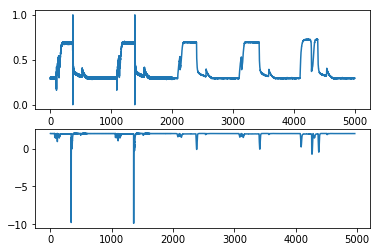

In [22]:
e_df1 = get_error(model.predict(X_df1),y_df1.reshape(-1,l))
print("e_df1 shape:", e_df1.shape)

p_df1 = multivariate_normal.pdf(x=e_df1, mean=u, cov=sigma, allow_singular=True)
plt.figure(1)
plt.subplot(211)
plt.plot(df1['value'])

plt.subplot(212)
plt.plot(np.log(p_df1))